In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# 1. Comparison of diffusion and optimimal transport trajectories

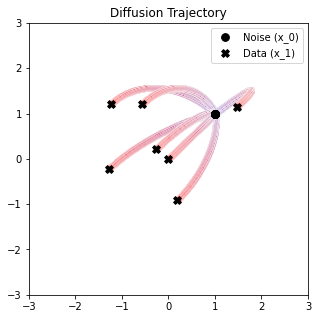

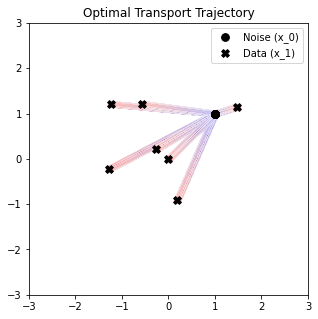

In [2]:
def diffusion_vector_field(t, x_t, x_1, beta_0=0.1, beta_1=20):
    def _compute_T(tt):
        return tt * beta_0 + 0.5 * (tt ** 2) * (beta_1 - beta_0)
    def _compute_T_prime(tt):
        return beta_0 + tt * (beta_1 - beta_0)
    T = _compute_T(1-t)
    T_prime = _compute_T_prime(1-t)
    scaler = -0.5 * T_prime
    numerator = (np.exp(-T) * x_t) - (np.exp(-0.5 * T) * x_1)
    denominator = 1 - np.exp(-T)
    u_t = scaler * numerator / denominator
    return u_t

def optimal_transport_vector_field(t, x_t, x_1, std_min=1e-8):
    numerator = x_1 - (1 - std_min) * x_t
    denominator = 1 - (1 - std_min) * t
    u_t = numerator / denominator
    return u_t

def optimal_transport_sample_at_t(t, x_1, std_min=1e-8):
    if isinstance(x_1, torch.Tensor):
        noise = torch.randn_like(x_1)
    else:
        noise = np.random.randn(*x_1.shape)
    mu_t = t * x_1
    std_t = 1 - (1 - std_min) * t
    return noise * std_t + mu_t

def mix_color(color_0, color_1, weight):
    return tuple([weight * c1 + (1 - weight) * c0 for c0, c1 in zip(color_0, color_1)])

def plot_trajectory(x_start, x_target, title, vf_type, n_timestep=1000):
    c_0 = (0, 0, 1) # time 0: blue
    c_1 = (1, 0, 0) # time 1: red
    x_t = x_start
    ts = np.linspace(0.0, 1.0-1/n_timestep, num=n_timestep) # time sequence for sampling

    plt.figure(figsize=(5, 5))
    plt.title(title);
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.scatter(x_start[:, 0], x_start[:, 1], color=(0, 0, 0), s=60, marker="o", zorder=2, label="Noise (x_0)");
    plt.scatter(x_target[:, 0], x_target[:, 1], color=(0, 0, 0), s=60, marker="X", zorder=2, label="Data (x_1)");
    for t in ts:
        if vf_type == "diffusion":
            u_t = diffusion_vector_field(t, x_t, x_target)
        elif vf_type == "optimal_transport":
            u_t = optimal_transport_vector_field(t, x_t, x_target)
        else:
            raise NotImplementedError()
        x_t = x_t + 1 / n_timestep * u_t
        c_t = mix_color(c_0, c_1, t)
        plt.scatter(x_t[:, 0], x_t[:, 1], alpha=0.3, color=c_t, edgecolor='white', s=40);
    plt.legend();
x_start = np.tile([1, 1], (7, 1))
x_target = np.append(np.random.randn(6, 2), [[0, 0]], axis=0)

plot_trajectory(x_start, x_target, "Diffusion Trajectory", "diffusion")
plot_trajectory(x_start, x_target, "Optimal Transport Trajectory", "optimal_transport")

# 2. Training flow matching with toy dataset

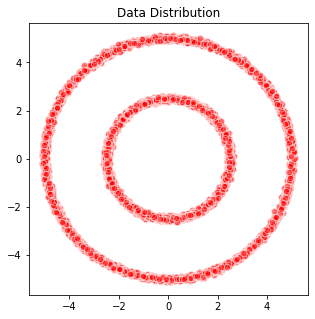

In [3]:
def sample_batch(size, factor=0.5, noise=0.01):
    x, y = make_circles(size, factor=0.5, noise=noise)
    x *= 5
    return x

N_DATA = 10000
data = sample_batch(N_DATA) # data: [N_DATA, 2]
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='red', edgecolor='white', s=40);
plt.title("Data Distribution");

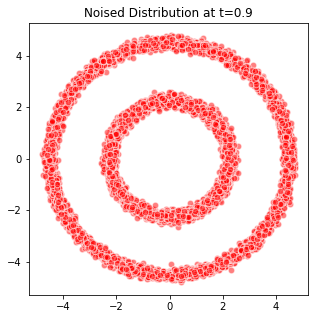

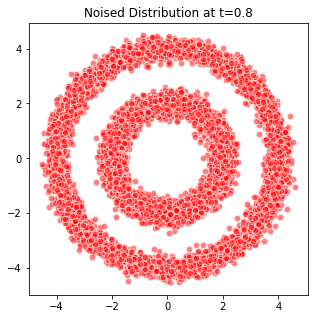

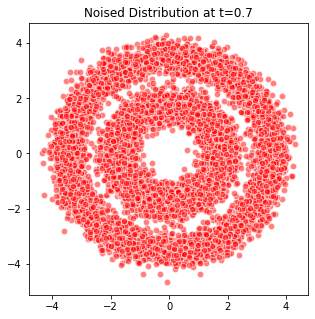

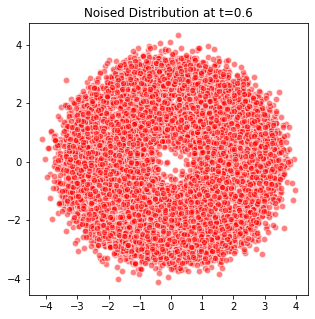

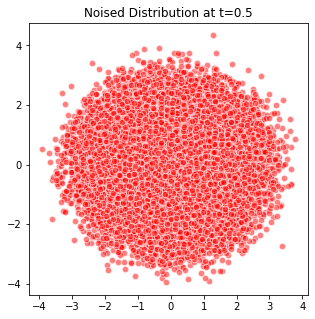

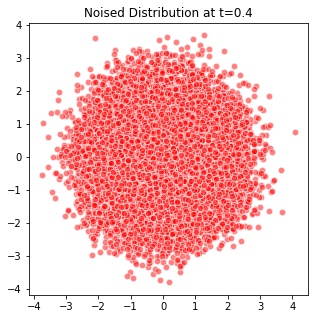

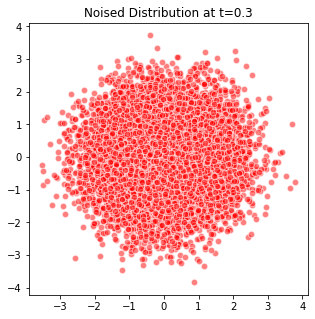

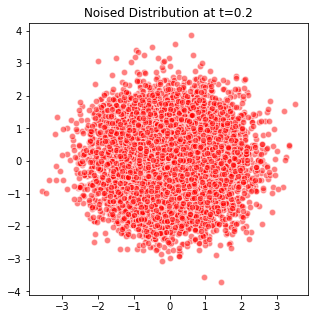

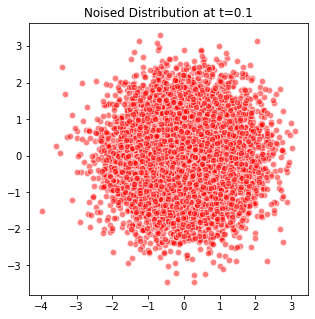

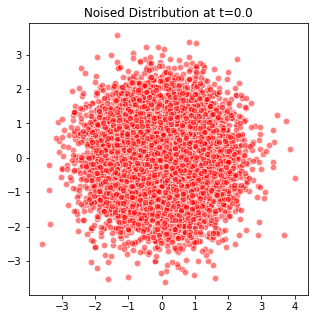

In [4]:
ts = np.linspace(0.9, 0.0, num=10)
for t in ts:
    t = round(t, 2)
    x_t = optimal_transport_sample_at_t(t, data)
    plt.figure(figsize=(5, 5))
    plt.scatter(x_t[:, 0], x_t[:, 1], alpha=0.5, color='red', edgecolor='white', s=40);
    plt.title(f"Noised Distribution at t={t}");

In [5]:
class Model(nn.Module):
    def __init__(self, hdim=256):
        super().__init__()
        self.fc1 = nn.Linear(3, hdim)
        self.fc2 = nn.Linear(hdim, hdim)
        self.fc3 = nn.Linear(hdim, 2)

    def forward(self, x, t):
        x_in = torch.cat((x, t), dim=1)
        h = F.silu(self.fc1(x_in))
        h = F.silu(self.fc2(h)) + h
        out = self.fc3(h)
        return out

    @torch.inference_mode()
    def infer(self, x, t):
        return self.forward(x, t)

device = "cuda"
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
dataset = TensorDataset(torch.from_numpy(data).float())
data_loader = DataLoader(dataset, shuffle=True, batch_size=16)

for epoch in range(1, 200):
    loss_lst = []
    for x in data_loader:
        x_1 = x[0].to(device) # x_1: [bsz, 2] 
        rand_t = torch.rand((x_1.shape[0], 1)).to(device) # [bsz, 1]
        x_t = optimal_transport_sample_at_t(rand_t, x_1)
        vf = optimal_transport_vector_field(rand_t, x_t, x_1)
        vf_est = model(x_t, rand_t)
        loss = (vf - vf_est).abs().mean()
        loss.backward()
        optimizer.step()
        loss_lst.append(loss.item())
    loss_avg = round(np.mean(loss_lst), 4)
    print(f'[Epoch: {epoch}] Training loss: {loss_avg}')

[Epoch: 1] Training loss: 1.8898
[Epoch: 2] Training loss: 1.8207
[Epoch: 3] Training loss: 1.7095
[Epoch: 4] Training loss: 1.7438
[Epoch: 5] Training loss: 1.677
[Epoch: 6] Training loss: 1.6867
[Epoch: 7] Training loss: 1.6776
[Epoch: 8] Training loss: 1.6977
[Epoch: 9] Training loss: 1.6889
[Epoch: 10] Training loss: 1.6671
[Epoch: 11] Training loss: 1.6729
[Epoch: 12] Training loss: 1.6644
[Epoch: 13] Training loss: 1.6687
[Epoch: 14] Training loss: 1.6599
[Epoch: 15] Training loss: 1.6707
[Epoch: 16] Training loss: 1.6529
[Epoch: 17] Training loss: 1.6659
[Epoch: 18] Training loss: 1.6513
[Epoch: 19] Training loss: 1.6647
[Epoch: 20] Training loss: 1.6784
[Epoch: 21] Training loss: 1.676
[Epoch: 22] Training loss: 1.6538
[Epoch: 23] Training loss: 1.6435
[Epoch: 24] Training loss: 1.6681
[Epoch: 25] Training loss: 1.6333
[Epoch: 26] Training loss: 1.64
[Epoch: 27] Training loss: 1.6525
[Epoch: 28] Training loss: 1.6362
[Epoch: 29] Training loss: 1.6103
[Epoch: 30] Training loss: 

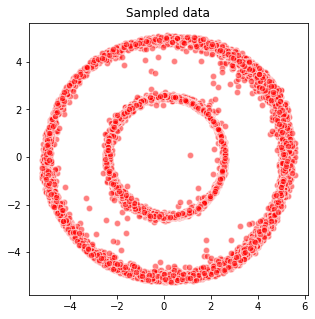

In [6]:
n_timestep = 1000
n_sample = 10000
ts = np.linspace(0.0, 1.0-1/n_timestep, num=n_timestep)
x_t = torch.randn(n_sample, 2).to(device)
model.eval()
for t in ts:
    t = torch.Tensor([t]).float().to(device)
    t = t.repeat(x_t.shape[0], 1)
    u_t = model.infer(x_t, t)
    x_t = x_t + 1 / n_timestep * u_t
x_t = x_t.cpu().numpy()
plt.figure(figsize=(5, 5))
plt.scatter(x_t[:, 0], x_t[:, 1], alpha=0.5, color='red', edgecolor='white', s=40);
plt.title("Sampled data");